In [135]:
import numpy as np
import matplotlib.pyplot as plt
import pydotplus 
import pandas as pd
from sklearn.datasets import load_boston, load_iris
from IPython.display import Image
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cross_validation import cross_val_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from tqdm import tqdm
import warnings
from collections import Counter
warnings.filterwarnings('ignore')
%matplotlib inline

### Теоретические задачи

#### #1

В задаче регрессии в лист попадают объекты выборки $X_1, X_2, ..., X_n$ с целевыми переменными $y_1, y_2, ..., y_n$.
<br> В первом случае оценкой является $M = \frac{1}{n}\sum_{i=1}^{n}{y_i}$.
<br> Во втором - $\xi$ с равномерным дискретным распределением на $y_1, y_2, ..., y_n$.
<br> Оценим матожидание $MSE$, обозначим $\widehat{y}$ оценку в общем случае, тогда:
<br> $E(\sum_{i=1}^{n}(\widehat{y} - y_i)^2) = \sum_{i=1}^{n}E(\widehat{y} - y_i)^2 = \sum_{i=1}^{n}Ey_i^2-2\sum_{i=1}^{n}Ey_i\widehat{y} + \sum_{i=1}^{n}E\widehat{y}^2$
<br> Посмотрим на слагамые в случае 1-ой и 2-ой оценок:
<br> 1-ое слагаемое независит от оценок, поэтому одинаковое в обоих случаях
<br> 2-ое слагаемое в первом случае $EM = M$, а во втором $E\frac{1}{n}\sum_{i=1}^{n}{y_i} = EM = M$
<br> 3-e слагаемое в первом случае: $EM^2 = M^2$, а во втором $E\xi^2$, но $E\xi^2 >= (E\xi)^2 = M^2$,
<br> таким образом во втором случае матожидание MSE не меньше, чем в первом, то есть оптимальнее отвечать средним значением.

#### #2

Как мы помним с лекции, при разбиении в каждом узле мы минимизируем взвешенный MSE, таким образом построение линейных моделей в листьях не должно дать никакого прироста в качестве, ведь мы не предполагаем никакой линейной зависимости данных в листе. Как вариант, можно попробовать минимизировать не MSE при разбиении, а разбивать данные, обучать линейные регрессии на разбиениях и снова минимизировать взвешенный MSE уже для регрессий, но это будет работать достаточно долго, так как потребуется находить оптимальные коэффициенты для регрессии, а это требует либо нахождения обратной матрицы и перемножения матриц (в случае аналитического решения) либо оптимизации, например из scipy.optimize в случае питона.

#### #3

Формула плотности многомерного нормального распределения:
<br> $p(x) = \frac{\displaystyle1}{\displaystyle(2\pi)^{n/2}|\Sigma|^{0.5}}e ^{-0.5(x-\mu)^T\Sigma^{-1}(x-\mu)} $,
<br> в таком случе энтропия нормального распределения:
<br> H(p) = $\displaystyle-\int...\int p(x)ln(p(x))dx = \displaystyle\int...\int p(x)(\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu) + ln((2\pi)^{n/2}|\Sigma|^{0.5}))dx=$
<br> $=\displaystyle \frac{1}{2}\displaystyle\Sigma_{ij}(E((x_i-\mu_i)(x_j-\mu_j))(\Sigma^{-1}_{ij})) + \frac{1}{2}ln((2\pi)^n|\Sigma|)= \frac{1}{2}\Sigma_i\Sigma_j(\Sigma)_{i,j}(\Sigma^{-1})_{i,j}+ \frac{1}{2}ln((2\pi)^n|\Sigma|) = $
<br> $=\displaystyle \frac{1}{2}\Sigma_i(\Sigma\Sigma^{-1})_{i,i}+ \frac{1}{2}ln((2\pi)^n|\Sigma|) = \frac{1}{2}\Sigma_i(E)_{i,i} + \frac{1}{2}ln((2\pi)^n|\Sigma|) = \frac{n}{2} + \frac{1}{2}ln((2\pi)^n|\Sigma|) = \frac{1}{2}ln((2\pi e)^n|\Sigma|)$

### Применение решающего дерева

In [2]:
data = pd.read_csv("german_credit.csv", index_col=False)

In [3]:
data.keys()

Index(['Creditability', 'Account Balance', 'Duration of Credit (month)',
       'Payment Status of Previous Credit', 'Purpose', 'Credit Amount',
       'Value Savings/Stocks', 'Length of current employment',
       'Instalment per cent', 'Sex & Marital Status', 'Guarantors',
       'Duration in Current address', 'Most valuable available asset',
       'Age (years)', 'Concurrent Credits', 'Type of apartment',
       'No of Credits at this Bank', 'Occupation', 'No of dependents',
       'Telephone', 'Foreign Worker'],
      dtype='object')

In [4]:
Counter(data['Creditability'])

Counter({0: 300, 1: 700})

Видим, что классы сильно несбалансированы, я не думаю, что в этом задании подразумевались преобразование признаков и балансировка классов, судя по времени выполнения (30 минут), но давайте сделаем хотя бы oversampling.

In [5]:
data.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


In [6]:
data.describe()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,...,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.700000,2.577000,20.903000,2.54500,2.828000,3271.24800,2.105000,3.384000,2.973000,2.68200,...,2.845000,2.358000,35.54200,2.675000,1.928000,1.407000,2.904000,1.155000,1.404000,1.037000
std,0.458487,1.257638,12.058814,1.08312,2.744439,2822.75176,1.580023,1.208306,1.118715,0.70808,...,1.103718,1.050209,11.35267,0.705601,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856
min,0.000000,1.000000,4.000000,0.00000,0.000000,250.00000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.000000,12.000000,2.00000,1.000000,1365.50000,1.000000,3.000000,2.000000,2.00000,...,2.000000,1.000000,27.00000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
50%,1.000000,2.000000,18.000000,2.00000,2.000000,2319.50000,1.000000,3.000000,3.000000,3.00000,...,3.000000,2.000000,33.00000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
75%,1.000000,4.000000,24.000000,4.00000,3.000000,3972.25000,3.000000,5.000000,4.000000,3.00000,...,4.000000,3.000000,42.00000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000
max,1.000000,4.000000,72.000000,4.00000,10.000000,18424.00000,5.000000,5.000000,4.000000,4.00000,...,4.000000,4.000000,75.00000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000


In [7]:
y = data['Creditability']
del data['Creditability']
X = data

In [8]:
X.head()

,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,Guarantors,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,1,1,1
1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,2,1,1
2,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,1,1,1
3,1,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2,2,1,2
4,1,12,4,0,2171,1,3,4,3,1,4,2,38,1,2,2,2,1,1,2


In [9]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Creditability, dtype: int64

In [10]:
ros = RandomOverSampler()

In [11]:
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_sample(X, y)

In [12]:
print (Counter(y_resampled))
print (X_resampled.shape)

Counter({0: 700, 1: 700})
(1400, 20)


In [13]:
train_data, test_data, train_target, test_target = train_test_split(X_resampled, y_resampled, test_size = 0.3)

In [14]:
# почему-то при большей глубине у меня вылетало с ошибкой при попытки визуализировать дерево, я не смог понять, в чём проблема
model = tree.DecisionTreeClassifier(max_depth=4)

In [15]:
target_names = ['0', '1']

In [16]:
model.fit(train_data, train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [17]:
dot_data = tree.export_graphviz(model, out_file="small_tree.out", 
                         feature_names=list(data.keys()),  
                         class_names=target_names,  
                         filled=True, rounded=False,  
                         special_characters=True)  

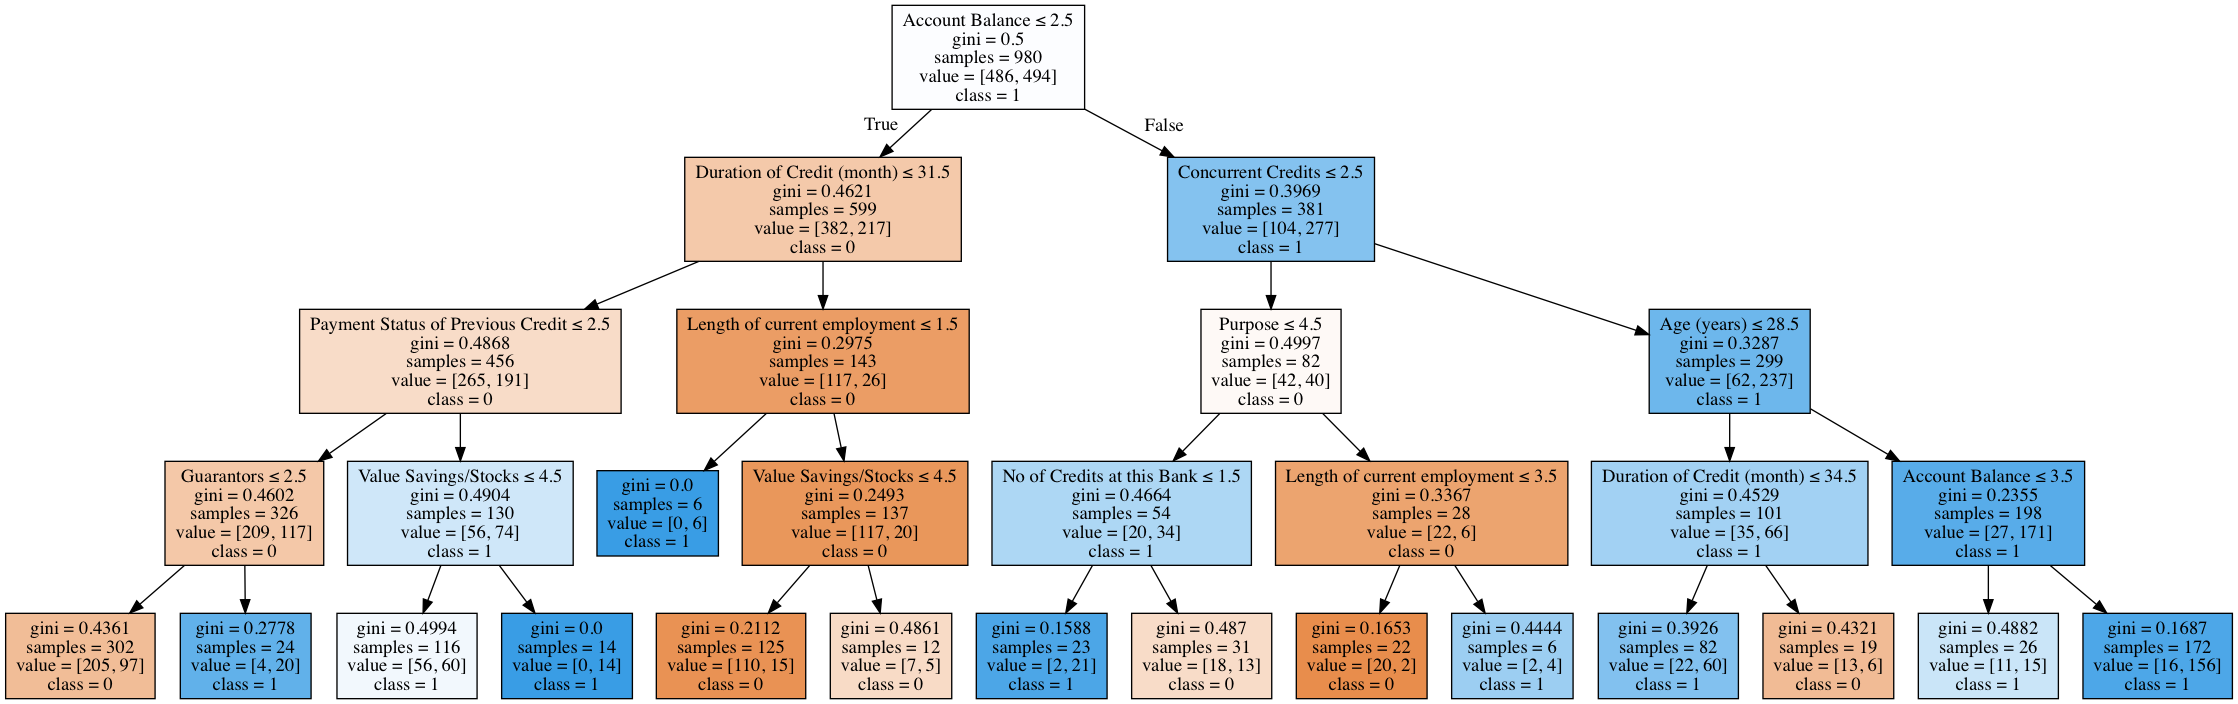

In [18]:
graph = pydotplus.graphviz.graph_from_dot_file("small_tree.out")  
Image(graph.create_png())  

Account Balance <= 3.5

Как я увидел из описания, Account Balance признак отвечаюющий количеству денег из интервала:

1 -> <100DM

2 -> 100DM<= ... < 500DM, 

3 -> 500DM<= ... < 1000DM,

4 -> >= 1000DM

Тогда логично, что кредит лучше выдавать людям с большим счётом (больше надежды, что они его вернут).

Duration of Credit (month) <= 11.5 - очевидно, что означает этот признак

Логично, что мы скорее выдадим кредит на не очень большой период, чем на очень большой срок.

Length of current employment <= 3.5 - также очевидно, что означает этот признак

Если посомотреть дальше на структуру дерева при ответах True и False в этом узле, то видно, что мы выдаём небольшие кредиты тем, у кого небольшой опыт работы, в то же время выдаём кредиты тем, у кого большой стаж и уже взято немного кредитов, либо им > 22.5 лет

In [19]:
cross_val_score(model, X_resampled, y_resampled, n_jobs=-1, cv=10)

array([ 0.67142857,  0.75      ,  0.78571429,  0.77142857,  0.82857143,
        0.76428571,  0.76428571,  0.69285714,  0.57857143,  0.69285714])

In [29]:
accuracy = []
for depth in tqdm(range(1, 25)):
    model = tree.DecisionTreeClassifier(max_depth=depth)
    accuracy.append(np.mean(cross_val_score(model, X_resampled, y_resampled, n_jobs=1, cv=10)))

100%|██████████| 24/24 [00:01<00:00, 18.13it/s]


In [21]:
accuracy

[0.67428571428571438,
 0.65142857142857147,
 0.6835714285714285,
 0.72999999999999998,
 0.72714285714285709,
 0.73642857142857143,
 0.75571428571428567,
 0.76071428571428579,
 0.77357142857142858,
 0.78785714285714281,
 0.79714285714285715,
 0.80357142857142849,
 0.81500000000000006,
 0.81500000000000006,
 0.8264285714285714,
 0.82071428571428573,
 0.81785714285714284,
 0.81928571428571428,
 0.8242857142857144,
 0.82499999999999996,
 0.82571428571428584,
 0.82571428571428584,
 0.8264285714285714,
 0.8264285714285714]

[]

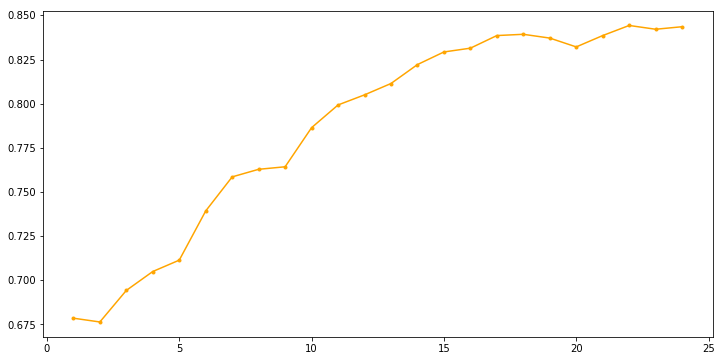

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 25), accuracy, color="orange", marker='.')
plt.plot()

### Реализация решающего дерева (опциональная часть)

In [31]:
boston = load_boston()

In [38]:
data = pd.DataFrame(boston.data)
data.columns = boston.feature_names
data['target'] = boston.target

In [39]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [40]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Нам нужно предсказывать target переменную, которая является вещественным признаком, поэтому будем строить дерево для регрессии

In [44]:
X = data.iloc[:, :-1]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data['target'], test_size=0.25)

In [132]:
model = tree.DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [134]:
mse1(model.predict(X_test), y_test)

4.350300921802563

In [127]:
def mse(y):
    try:
        y_mean = y.mean()
    except AttributeError:
        y = np.array(y)
        y_mean = y.mean()
    return ((y - y_mean) ** 2).mean()

def criterion(left, right, root):
        return len(left) / len(root) * mse(left) + len(right) / len(root) * mse(right)

class DecisionRule:
    def __init__(self, k, bound):
        self.k = k
        self.bound = bound

    def __call__(self, x):
        return not x[self.k] < self.bound

class TreeNode:
    EPS = 1e-5

    def __init__(self, tree, depth=0):
        self.depth = depth
        self.tree = tree
        self.edges = list()
        self.rule = None
        self.inds = list()

    def get_class(self, x):
        if not self.edges:
            return self.tree.y[self.inds].mean()
        return self.edges[self.rule(x)].get_class(x)

    def _get_classes(self, inds):
        return Counter(self.tree.y[inds])

    def _split_inds(self, inds, bound, k):
        left = list(filter(lambda idx: self.tree.X[idx][k] < bound - TreeNode.EPS, inds))
        right = list(filter(lambda idx: not self.tree.X[idx][k] < bound - TreeNode.EPS, inds))
        return left, right

    def learn(self, inds):
        self.inds = inds
        if self.depth == self.tree.max_depth or len(inds) < self.tree.min_items:
            return
        best_k = -1
        best_bound = -1
        c_value = float('Inf')
        for k in range(len(self.tree.bounds)):
            for bound in self.tree.bounds[k]:
                left, right = self._split_inds(inds, bound, k)

                new_c_value = criterion(left, right, inds)
                if new_c_value < c_value:
                    best_k, best_bound = k, bound
                    c_value = new_c_value
        if best_k == -1:
            return
        self.rule = DecisionRule(best_k, best_bound)
        left, right = self._split_inds(inds, best_bound, best_k)
        l_node = TreeNode(self.tree, self.depth + 1)
        r_node = TreeNode(self.tree, self.depth + 1)
        l_node.learn(left)
        r_node.learn(right)
        self.edges = [l_node, r_node]


class DecisionTree:
    
    def __init__(self, max_depth=3, min_items=5):
        self.root = TreeNode(self)
        self.X = None
        self.y = None
        self.bounds = None
        self.max_depth = max_depth
        self.min_items = min_items

    def fit(self, X, y):
        self.X = np.asarray(X)
        self.y = np.asarray(y)
        self.bounds = list()
        for k in range(X.shape[1]):
            self.bounds.append(np.linspace(np.min(self.X[:, k]), np.max(self.X[:, k]), num=10))
        self.root.learn(list(range(len(X))))

    def predict(self, X):
        return [self.root.get_class(x) for x in np.asarray(X)]

In [128]:
model = DecisionTree()

In [129]:
model.fit(X_train, y_train)

In [130]:
def mse1(y, y_test):
    return (((np.array(y) - np.array(y_test)) ** 2).mean()) ** 0.5

In [131]:
mse1(model.predict(X_test), y_test)

8.3642757254935827